# Import Library

In [18]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential

print(tf.__version__)


2.12.0


# Add Dataset Model

In [19]:
train_dir = Path('../dataset/')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [20]:
test_dir = Path('../dataset/test/')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [21]:
val_dir = Path('../dataset/validation/')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

# Get Labels With Folder Image

In [22]:
def image_processing(filepath):
    # Create Label
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [23]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

## Looks Dataset

In [24]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3165

Number of different labels: 30

Labels: ['kentang_goreng' 'bakso_kuah' 'sayur_asam' 'ikan_goreng' 'cumi_tepung'
 'sayur_bayam' 'lemon' 'tahu_goreng' 'kacang_rebus' 'somay' 'sate_bakar'
 'pear' 'telur_dadar' 'apel' 'mie_goreng' 'nasi_goreng' 'gado_gado'
 'gulai_ikan' 'tempe_goreng' 'ayam_goreng' 'daging_rendang' 'telur_balado'
 'semangka' 'pempek' 'mie_kuah' 'ayam_pop' 'mangga' 'opor_ayam' 'pisang'
 'nanas']


In [25]:
# Check label ind folder
train_df.head(5)

,Filepath,Label
0,../dataset/train/kentang_goreng/homemade-frenc...,kentang_goreng
1,../dataset/train/bakso_kuah/91eb3de9868563ab48...,bakso_kuah
2,../dataset/train/sayur_asam/sayur-asem-malang-...,sayur_asam
3,../dataset/train/ikan_goreng/b4db1541-2b96-4d9...,ikan_goreng
4,../dataset/validation/cumi_tepung/19_five-spic...,cumi_tepung


## Test Labels With Image

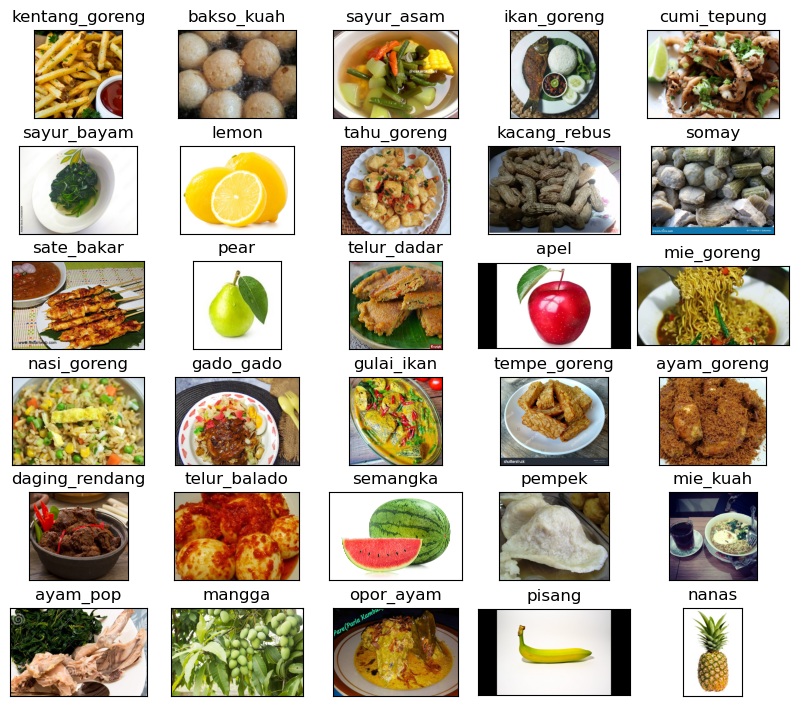

In [26]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# Image Preprocessing With MobileNet V2

In [27]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [29]:
# Train Dataset
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 3165 validated image filenames belonging to 30 classes.


In [30]:
# Davlidation dataset
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 498 validated image filenames belonging to 30 classes.


In [31]:
# Testing Dataset
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 498 validated image filenames belonging to 30 classes.


# Train Model Machine Learning With Tranfer Learning MobileNetV2

## Pre Training Model

In [33]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

## Callbacks

In [34]:
# Setting Callbacks
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95:
            print("\nReached 95% accuracy in training and 95% in validation, so cancelling training!")
            self.model.stop_training = True

callbackTraining = myCallback()

## Training Model

In [35]:
# Model Layers
model = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224), 
    tf.keras.layers.Normalization(axis=-1),
    pretrained_model,
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(30, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Train the model (initial training)
history = model.fit(
    train_images, 
    validation_data=val_images, 
    batch_size=32, 
    callbacks=[callbackTraining],
    epochs=50)

Epoch 1/50


2023-12-10 08:13:37.911558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - ETA: 0s - loss: 3.2205 - accuracy: 0.1330

2023-12-10 08:14:35.317132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 67s 666ms/step - loss: 3.2205 - accuracy: 0.1330 - val_loss: 2.7898 - val_accuracy: 0.3293
Epoch 2/50
99/99 [==============================] - 65s 649ms/step - loss: 2.3682 - accuracy: 0.4626 - val_loss: 1.8023 - val_accuracy: 0.6365
Epoch 3/50
99/99 [==============================] - 66s 661ms/step - loss: 1.4869 - accuracy: 0.6979 - val_loss: 1.0727 - val_accuracy: 0.8012
Epoch 4/50
99/99 [==============================] - 65s 661ms/step - loss: 0.9820 - accuracy: 0.7968 - val_loss: 0.7144 - val_accuracy: 0.8695
Epoch 5/50
99/99 [==============================] - 66s 664ms/step - loss: 0.7301 - accuracy: 0.8414 - val_loss: 0.5279 - val_accuracy: 0.9116
Epoch 6/50
99/99 [==============================] - 67s 677ms/step - loss: 0.5786 - accuracy: 0.8793 - val_loss: 0.4145 - val_accuracy: 0.9277
Epoch 7/50
99/99 [==============================] - 69s 696ms/step - loss: 0.4798 - accuracy: 0.9014 - val_loss: 0.3279 - val_accuracy: 0.9578
Epoch 8/50

## Arsitektur Model

In [37]:
# Check Arsitektur model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, None)    0         
                                                                 
 normalization_1 (Normalizat  (None, 224, 224, 3)      7         
 ion)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 30)               

## Grapic Model

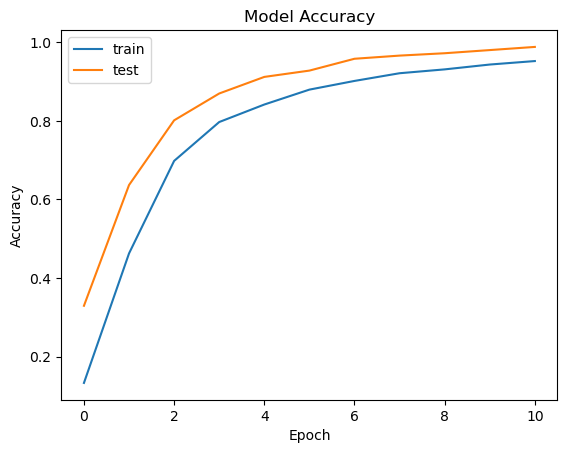

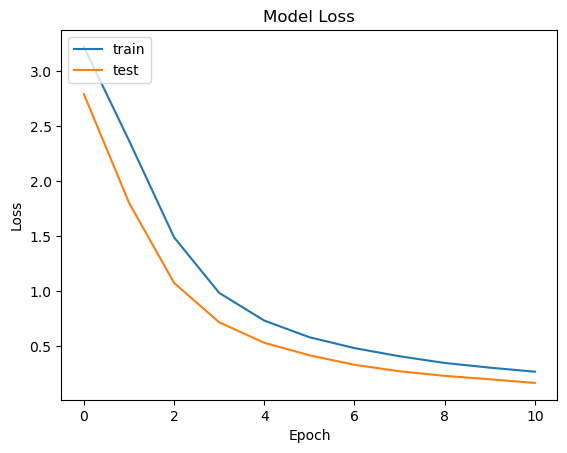

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Check Point Model

In [39]:
# Save the best model during initial training
checkpoint_path = "initial_training_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)


## Setting Callbacks Fine-Tuning

In [40]:
# Setting Callbacks
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95:
            print("\nReached 95% accuracy in training and 95% in validation, so cancelling training!")
            self.model.stop_training = True

callbackFineTuning = myCallback()

## Fine-Tuning Model

In [41]:
# Unfreeze some layers for fine-tuning
for layer in model.layers[:100]: 
    layer.trainable = True

# Recompile the model with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Continue training with fine-tuning
history_fine_tuning = model.fit(
    train_images, 
    validation_data=val_images, 
    callbacks=[callbackFineTuning],
    batch_size=32, 
    epochs=50)


Epoch 1/50


2023-12-10 08:49:37.302012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - ETA: 0s - loss: 1.0934 - accuracy: 0.7043

2023-12-10 08:51:14.402588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 107s 1s/step - loss: 1.0934 - accuracy: 0.7043 - val_loss: 0.1874 - val_accuracy: 0.9618
Epoch 2/50
99/99 [==============================] - 102s 1s/step - loss: 0.6281 - accuracy: 0.8404 - val_loss: 0.2026 - val_accuracy: 0.9518
Epoch 3/50
99/99 [==============================] - 103s 1s/step - loss: 0.4673 - accuracy: 0.8983 - val_loss: 0.1977 - val_accuracy: 0.9498
Epoch 4/50
99/99 [==============================] - 104s 1s/step - loss: 0.3593 - accuracy: 0.9232 - val_loss: 0.1687 - val_accuracy: 0.9598
Epoch 5/50
99/99 [==============================] - 102s 1s/step - loss: 0.3001 - accuracy: 0.9368 - val_loss: 0.1450 - val_accuracy: 0.9659
Epoch 6/50
99/99 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.9627
Reached 95% accuracy in training and 95% in validation, so cancelling training!
99/99 [==============================] - 103s 1s/step - loss: 0.2404 - accuracy: 0.9627 - val_loss: 0.1246 - val_accuracy: 0.9699


## Testing model 

In [45]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

2023-12-10 09:17:25.577021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 9s 577ms/step


['cumi_tepung',
 'apel',
 'telur_balado',
 'gado_gado',
 'tahu_goreng',
 'sayur_bayam',
 'telur_balado',
 'daging_rendang',
 'daging_rendang',
 'ayam_pop',
 'sayur_asam',
 'tempe_goreng',
 'lemon',
 'semangka',
 'kacang_rebus',
 'telur_dadar',
 'sayur_asam',
 'opor_ayam',
 'kentang_goreng',
 'lemon',
 'telur_balado',
 'telur_dadar',
 'cumi_tepung',
 'ikan_goreng',
 'pisang',
 'nasi_goreng',
 'gulai_ikan',
 'mangga',
 'pear',
 'kacang_rebus',
 'sayur_bayam',
 'somay',
 'ikan_goreng',
 'mie_goreng',
 'ikan_goreng',
 'telur_dadar',
 'mie_kuah',
 'pempek',
 'kentang_goreng',
 'telur_balado',
 'mie_goreng',
 'kentang_goreng',
 'kentang_goreng',
 'sate_bakar',
 'somay',
 'telur_balado',
 'ikan_goreng',
 'apel',
 'apel',
 'tahu_goreng',
 'bakso_kuah',
 'lemon',
 'sayur_bayam',
 'cumi_tepung',
 'ayam_goreng',
 'tempe_goreng',
 'telur_dadar',
 'telur_balado',
 'telur_balado',
 'sayur_asam',
 'ikan_goreng',
 'sayur_bayam',
 'mie_kuah',
 'sate_bakar',
 'sayur_asam',
 'opor_ayam',
 'nanas',
 'tahu

In [46]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

# Convert Model ML

## Convert Model .h5

In [47]:
# Convert the model to .h5 format
model.save('save_model.h5')

## Convert Model .tflite

In [48]:
# Convert the model to tflite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('save_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmpwpyoolfc/assets


INFO:tensorflow:Assets written to: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmpwpyoolfc/assets
2023-12-10 09:19:05.731966: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-12-10 09:19:05.731987: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-12-10 09:19:05.732686: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmpwpyoolfc
2023-12-10 09:19:05.753431: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-12-10 09:19:05.753450: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmpwpyoolfc
2023-12-10 09:19:05.823371: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-12-10 09:19:05.846251: I tensorflow/cc/saved_model/load